In [1]:
#importing the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Mounted at /content/drive


In [2]:
#for nltk
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
#for sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle, re

In [4]:
#fetching the dataset
df_path = '/content/drive/MyDrive/amazon_alexa.tsv'
df = pd.read_csv(df_path, delimiter='\t', quoting=3)
df


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1


# Exploratory Data Analysis

In [5]:
df['verified_reviews']   #validating the reviews column

,verified_reviews
0,Love my Echo!
1,Loved it!
2,"""Sometimes while playing a game, you can answe..."
3,"""I have had a lot of fun with this thing. My 4..."
4,Music
...,...
3145,"""Perfect for kids, adults and everyone in betw..."
3146,"""Listening to music, searching locations, chec..."
3147,"""I do love these things, i have them running m..."
3148,"""Only complaint I have is that the sound quali..."


In [6]:
df.info()  #checking if there are any null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [7]:
df.isnull().sum()
#there is one null value in the verified_review column

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [8]:
#fetching the null value
df[df['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [9]:
df.dropna(inplace = True)   #droppping the null value

In [10]:
df.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,0
feedback,0


In [11]:
#creating the new column that will contain the length of verified_review
df['length'] = df['verified_reviews'].apply(len)
df

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1,52
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1,137
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1,443
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1,382


In [12]:
#analysing the rating column
print(f'Rating value count: \n {df["rating"].value_counts()}')

Rating value count: 
 rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


In [13]:
len(df)

3149

There are total 3149 records out of which, 2286 are 5 starred and 455 are 4 starred from which we can conclude that the reviews are positive.

Text(0, 0.5, 'Counts')

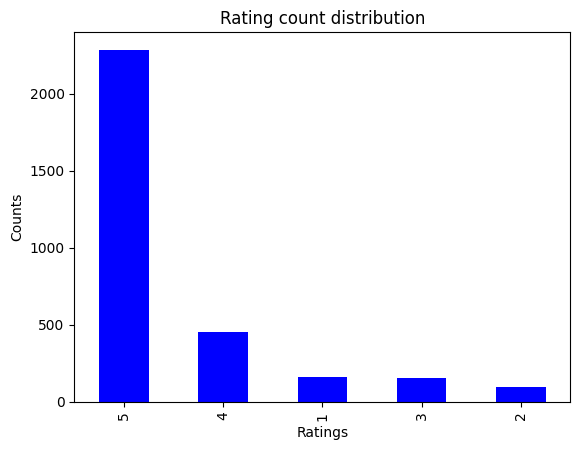

In [14]:
#visualizing in the form of bargraph
df['rating'].value_counts().plot.bar(color='blue')
plt.title('Rating count distribution')
plt.xlabel('Ratings')
plt.ylabel('Counts')
# plt.xticks(rotation = 360)

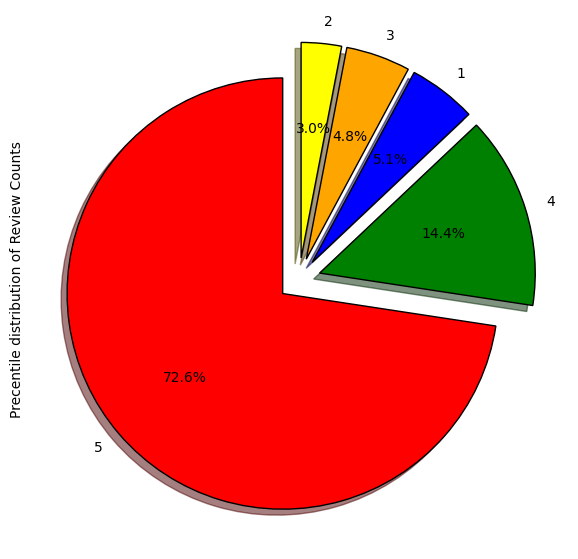

In [15]:
#let's experiment the dataset with pie-chart
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green', 'blue', 'orange', 'yellow')
wp = {'linewidth':1, 'edgecolor':'black'}
tags = df['rating'].value_counts()/df.shape[0]
explode = (0.1,0.1,0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow = True, colors = colors, startangle = 90, wedgeprops = wp, explode = explode, label = 'Precentile distribution of Review Counts')
from io import BytesIO
graph = BytesIO()
fig.savefig(graph, format='png')

In [16]:
#analysing feedback column
print(f"Feedback value Count: \n{df['feedback'].value_counts()}")

Feedback value Count: 
feedback
1    2893
0     256
Name: count, dtype: int64


There are two values in the feedback column, 1 and 0 which is abit confusing so we need to further analyse the contents.

In [17]:
rev_0 = df[df['feedback'] == 0].iloc[1]['verified_reviews']
print(rev_0)

Sound is terrible if u want good music too get a bose


In [18]:
rev_1 = df[df['feedback'] == 1].iloc[1]['verified_reviews']
print(rev_1)

Loved it!


By analsying the reviews of 1 and 0 feedback column, we might conclude that feedback 1 is a positive review and feedback 0 is the negative review.

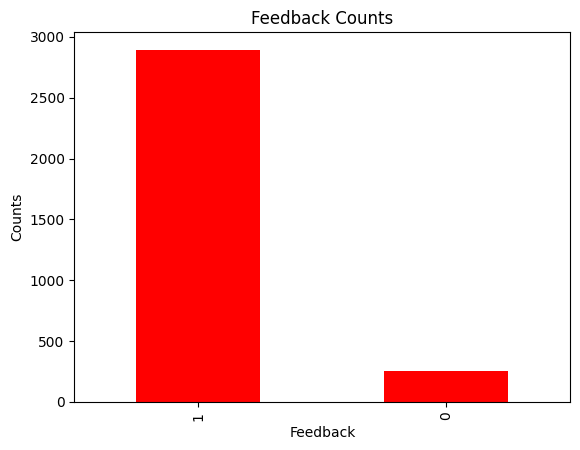

In [19]:
#let's plot the graph according to the feedback column
df['feedback'].value_counts().plot.bar(color = 'red')
plt.title('Feedback Counts')
plt.xlabel('Feedback')
plt.ylabel('Counts')
plt.show()

<Axes: ylabel='Pie chart of feedback column'>

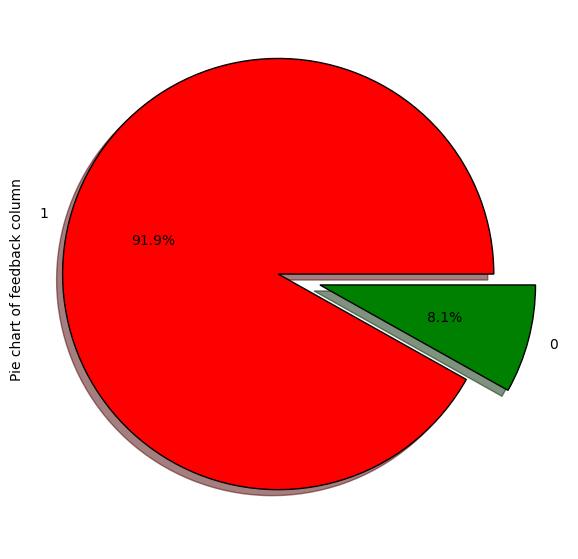

In [20]:
#building pie chart according to the feedback column
fig = plt.figure(figsize = (7,7))
colors = ('red', 'green')
wp = {'linewidth':1, 'edgecolor':'black'}
tags = df['feedback'].value_counts()/df.shape[0]
explode = (0.1, 0.1)
tags.plot(kind = 'pie', autopct= "%1.1f%%", shadow = True, colors = colors, wedgeprops = wp, explode = explode, label = 'Pie chart of feedback column')

Lets understand the relation between feedback and ratings coolumn.

In [21]:
#feedback 0
df[df['feedback'] == 0]['rating'].value_counts()

,count
rating,
1,161
2,95


In [22]:
#feedback 1
df[df['feedback'] == 1]['rating'].value_counts()

,count
rating,
5,2286
4,455
3,152


From this we get to know that the feedback 0 contains (1 and 2) rating which is also negative rating, and feedback 1 contains (3,4,5) rating which is positive rating.

In [23]:
#analysing variation column
print(f"Variations value count: \n {df['variation'].value_counts()}")

Variations value count: 
 variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


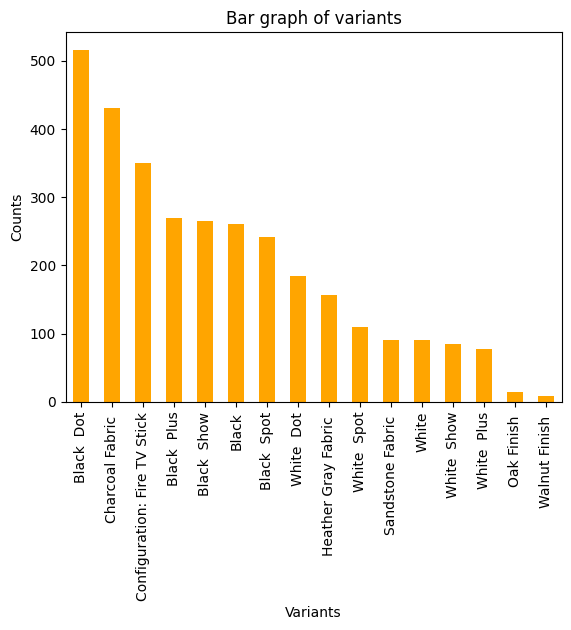

In [24]:
#varitaion counts distribution
df['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Bar graph of variants')
plt.ylabel('Counts')
plt.xlabel('Variants')
plt.show()


So, the highest selling varient is Black Dot which is 516.

In [25]:
#mean rating according to variation
df.groupby('variation')['rating'].mean()

,rating
variation,
Black,4.233716
Black Dot,4.453488
Black Plus,4.370370
Black Show,4.490566
Black Spot,4.311203
Charcoal Fabric,4.730233
Configuration: Fire TV Stick,4.591429
Heather Gray Fabric,4.694268
Oak Finish,4.857143


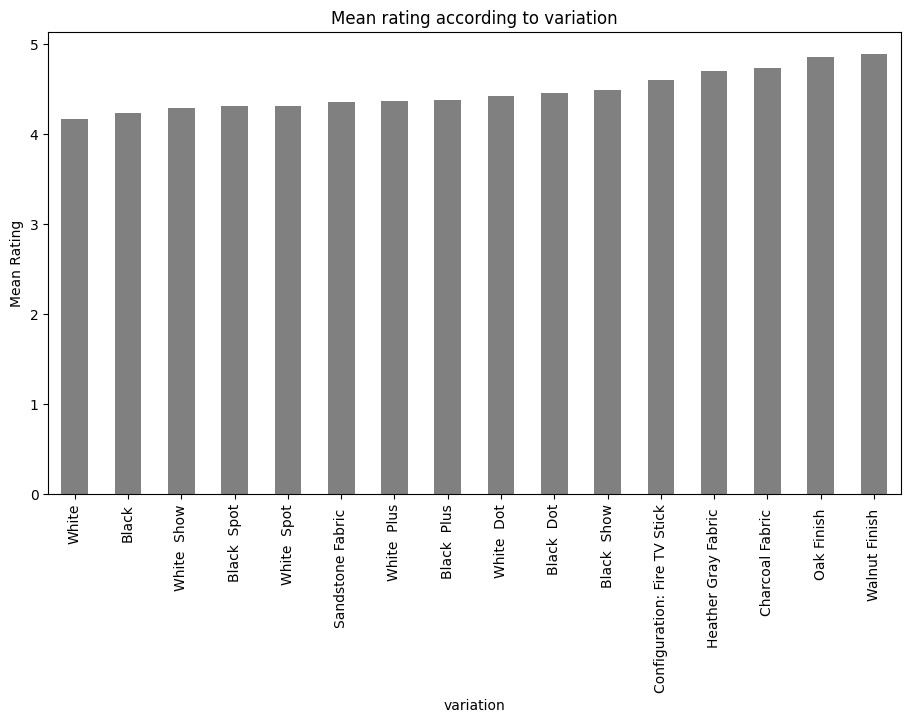

In [26]:
#bar-plot of ratings
df.groupby('variation')['rating'].mean().sort_values().plot.bar(color='gray', figsize = (11,6))
plt.title('Mean rating according to variation')
plt.xlabel('variation')
plt.ylabel('Mean Rating')
plt.show()

We can see that the people who have taken Walnut Finish, are happy with their product

In [27]:
#analysing verified_reviews (this column contains the textual review data)
df['length'].describe()

,length
count,3149.000000
mean,132.714513
std,182.541531
min,1.000000
25%,30.000000
50%,74.000000
75%,166.000000
max,2853.000000


[Text(0.5, 1.0, 'Distribution of length')]

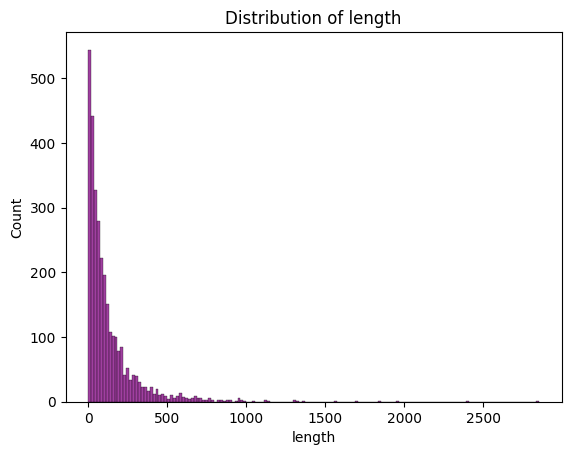

In [28]:
sns.histplot(df['length'],color = 'purple').set(title='Distribution of length')

The length of rating is more between 1 to 500 letters.

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

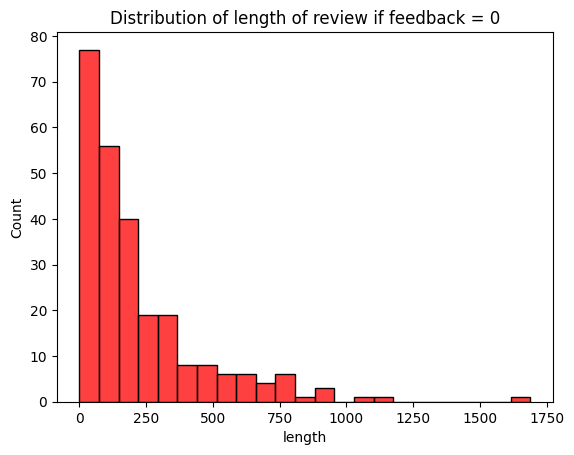

In [29]:
#length analysis when feedback is 0 (negative review)
sns.histplot(df[df['feedback']== 0]['length'],color ='red').set(title = 'Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

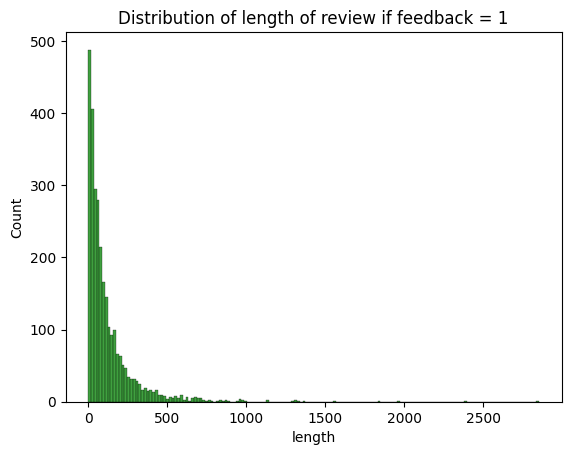

In [30]:
#length analysis when feedback is 1 (positive review)
sns.histplot(df[df['feedback']== 1]['length'],color ='green').set(title = 'Distribution of length of review if feedback = 1')

The negative reviews are shorter in length whereas the positive reviews are longer in terms of length.

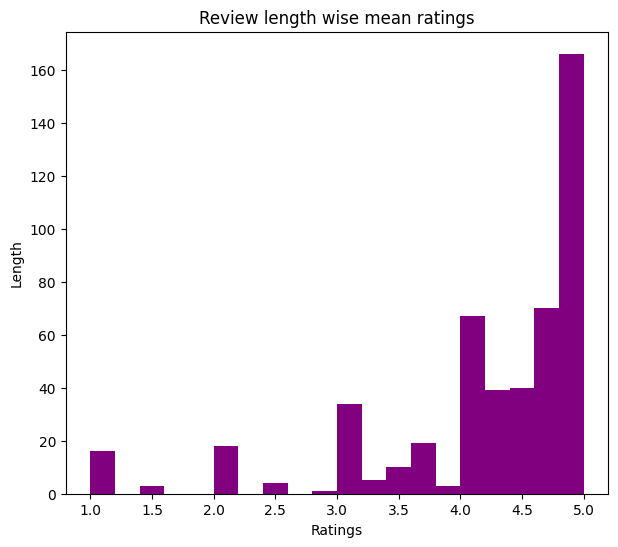

In [31]:
#length wise mean rating
df.groupby('length')['rating'].mean().plot.hist(color = 'purple', figsize=(7,6), bins=20)
plt.title('Review length wise mean ratings')
plt.xlabel('Ratings')
plt.ylabel('Length')
plt.show()

From the above histograph we can verify that the positive reviews are longer in terms of length.

In [32]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.verified_reviews)

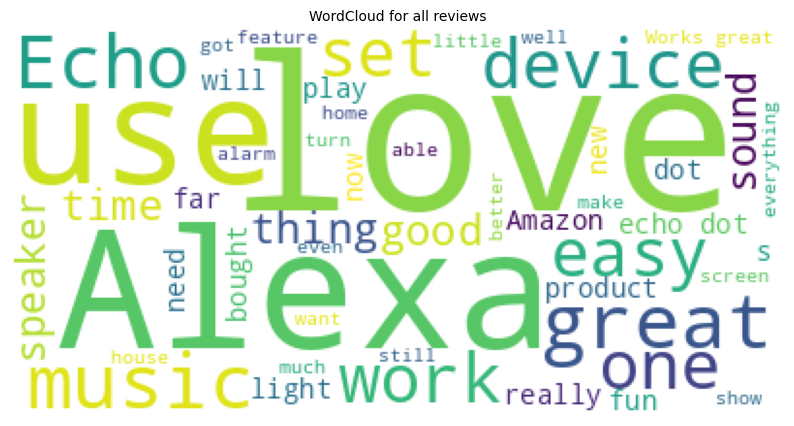

In [33]:
#combine all reviews
reviews = " ".join([review for review in df['verified_reviews']])

#initialize wordcloud object
wc = WordCloud(background_color='white', max_words = 50)

#generate and plot wordcloud
plt.figure(figsize = (10,10))
plt.imshow(wc.generate(reviews))
plt.title('WordCloud for all reviews', fontsize = 10)
plt.axis('off')
plt.show()

In [34]:
#lets try to divide the data into positive and negative reviews
neg_reviews = " ".join([review for review in df[df['feedback']==0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in df[df['feedback']==1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#finding unique words
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = ' '.join(unique_negative)
unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = ' '.join(unique_positive)

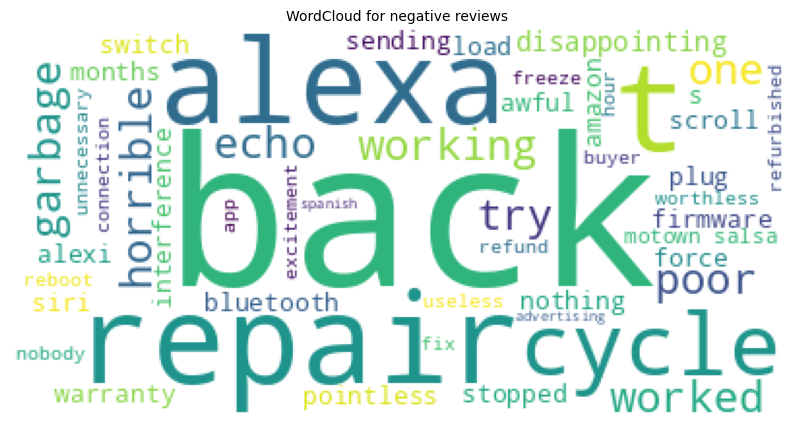

In [35]:
#wordcolud generation
wc = WordCloud(background_color = 'white', max_words = 50)
#generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title("WordCloud for negative reviews", fontsize = 10)
plt.axis('off')
plt.show()

We can see the negative words such as: useless, refund, awful, etc.

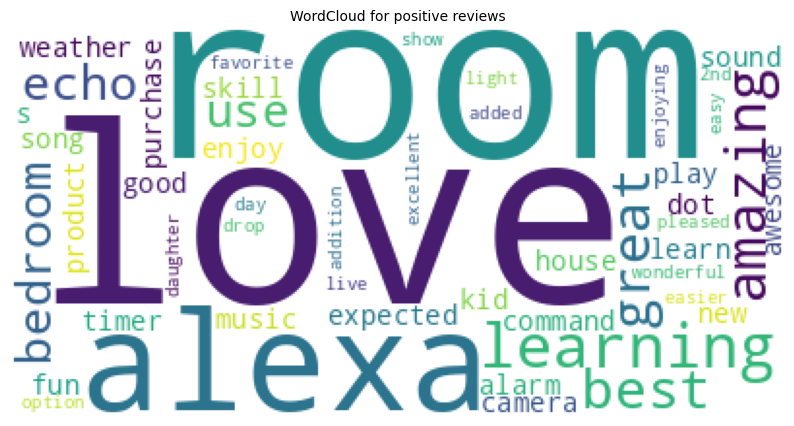

In [36]:
#wordcolud generation
wc = WordCloud(background_color = 'white', max_words = 50)
#generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title("WordCloud for positive reviews", fontsize = 10)
plt.axis('off')
plt.show()

We can see the positive words such as fun, best, excellent, etc.

# Model building and Preprocessing

For building the corpus (which is generally the raw useful material of text) from verified_reviews we do these following steps:
- Replace non alphabetical characters with string
- Convert into lowercase and split into words
- Iterate over the individual words  and if it is not a stopword then add the stemmed form of word to the corpus

In [37]:
corpus = []
stemmer = PorterStemmer()
for i in range (0, df.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [38]:
# using count vectorizer to create bag of words
cv = CountVectorizer(max_features = 2500)

#storing dependent and independent variables in X and y
x = cv.fit_transform(corpus).toarray()
y = df['feedback'].values

In [39]:
#saving the count vectorizer
# pickle.dump(cv, open('Models/count_vectorizer.pkl','wb'))
with open('count_vectorizer.pkl', 'wb') as f:
    pickle.dump(cv, f)
#download the pickle file
# files.download('data.pkl')


In [40]:
print(f'Dimension of x is:{x.shape}')
print(f'Dimension of y is:{y.shape}')

Dimension of x is:(3149, 2500)
Dimension of y is:(3149,)


Splitting the data into train and test with 30% of testing data

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 15)
print(f"x train:{x_train.shape}")
print(f"y train:{y_train.shape}")
print(f"x test:{x_test.shape}")
print(f"y test:{y_test.shape}")

x train:(2204, 2500)
y train:(2204,)
x test:(945, 2500)
y test:(945,)


In [42]:
print(f'x train max value:{x_train.max()}')
print(f"x test max value:{x_test.max()}")

x train max value:12
x test max value:10


We will scale the x_train and x_test such that all the value is between 0 and 1.

In [43]:
scalar = MinMaxScaler()
x_test_scl = scalar.fit_transform(x_test)
x_train_scl = scalar.transform(x_train)

In [44]:
#saving the scalar model
with open('scalar.pkl', 'wb') as f:
    pickle.dump(scalar, f)

## Random Forest

In [45]:
#fitting scaled x_train and y_train on random forest classifier
model_rf = RandomForestClassifier()
model_rf.fit(x_train_scl, y_train)

RandomForestClassifier()

In [46]:
#accuracy of the model in training and testing data
print(f'Accuracy of the training data:{model_rf.score(x_train_scl, y_train)}')
print(f'Accuracy of the testing data:{model_rf.score(x_test_scl, y_test)}')

Accuracy of the training data:0.9945553539019963
Accuracy of the testing data:0.944973544973545


In [47]:
#predicting on the test set
y_preds = model_rf.predict(x_test_scl)

In [48]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_preds)

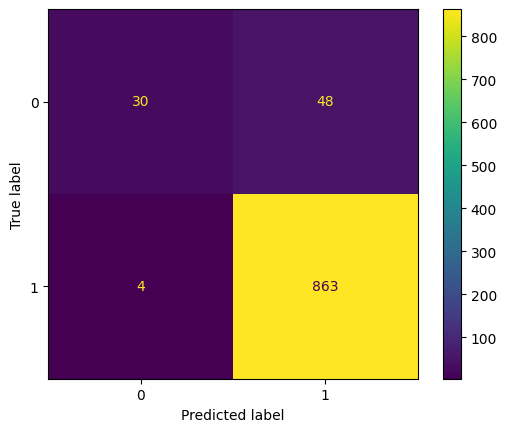

In [49]:
# Create confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)

# Plot the confusion matrix
cm_display.plot()

# Show the plot
plt.show()


## k- fold cross validation

In this particular part we have made cross-validating the data into test and training sets. For this particualr part, we have divided into 10 fold cross validation which means, data is split into 10 parts. The model is trained on 9 parts and tested on remaining 1 part, this process is repeated 10 times with each fold serving as the test set score.

In [50]:
accuracies = cross_val_score(estimator= model_rf, X = x_train_scl, y = y_train, cv = 10)
print('Accuracy:',accuracies.mean())
print('Standard Variance:', accuracies.std())

Accuracy: 0.9324002468120115
Standard Variance: 0.008442059497043464


In [51]:
# hyperparameter tuning
params = {
    'bootstrap': [True],
    'max_depth': [80,100],
    'min_samples_split': [8,12],
    'n_estimators': [100,300]
}

'bootstrap': True ( indicates that the model should use bootstrapping when building trees.)
 - Bootstrapping is a sampling method where a subset of data is randomly chosen with replacement to train each individual tree in the ensemble model (like Random Forest). It helps improve the robustness and generalization of the model.

'max_depth': [80,100] ( list contains two values, 80 and 100, representing the possible maximum depths of the trees in the model.)

'min_samples_split': [8,12], controls how deep each tree in the model can grow. A deeper tree can model more complex patterns but may lead to overfitting.
 parameter defines the minimum number of samples required to split an internal node.

'n_estimators': [100,300] This parameter determines the number of trees in the forest. More trees generally lead to better performance, but they also increase computation time.

In [53]:
cv_object = StratifiedKFold(n_splits=2)
grid_search = GridSearchCV(estimator=model_rf, param_grid=params, cv = cv_object, verbose = 0, return_train_score=True)
grid_search.fit(x_train_scl, y_train.ravel())
# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 12, 'n_estimators': 100}


In [54]:
print("Cross Validation mean accuracy on train set:{}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross Validation mean accuracy on test set:{}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set:",accuracy_score(y_test, y_preds))

Cross Validation mean accuracy on train set:96.8296279491833
Cross Validation mean accuracy on test set:92.21869328493648
Accuracy score for test set: 0.944973544973545


## XgBoost

XGBoost uses gradient boosting to iteratively build an ensemble of decision trees, improving prediction accuracy by correcting the errors of previous models.

In [55]:
model_xgb = XGBClassifier()
model_xgb.fit(x_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [56]:
#accuracy of the model by using xgboost
print("Training accuracy:", model_xgb.score(x_train_scl, y_train))
print("Testing Accuracy:", model_xgb.score(x_test_scl, y_test))

Training accuracy: 0.971415607985481
Testing Accuracy: 0.9417989417989417


In [58]:
y_preds = model_xgb.predict(x_test)

In [59]:
#confusion matrix
cm = confusion_matrix(y_test, y_preds)
cm

array([[ 31,  47],
       [ 13, 854]])

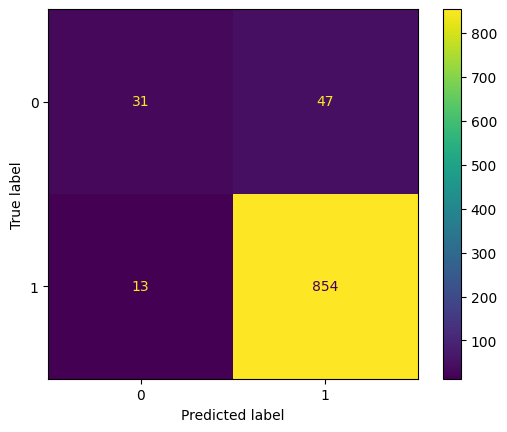

In [60]:
#displaying confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [61]:
#saving the xgboost classifier in pickle form
with open('model_xgb.pkl', 'wb') as f:
    pickle.dump(model_xgb, f)

## Decision tree classifier

In [62]:
model_dt = DecisionTreeClassifier()
model_dt.fit(x_train_scl, y_train)

DecisionTreeClassifier()

In [63]:
#accuracy of the model in training and testing of the data
print(f'Accuracy of the training data:{model_dt.score(x_train_scl, y_train)}')
print(f'Accuracy of the testing data:{model_dt.score(x_test_scl, y_test)}')

Accuracy of the training data:0.9945553539019963
Accuracy of the testing data:0.9227513227513228


In [64]:
y_preds = model_dt.predict(x_test)

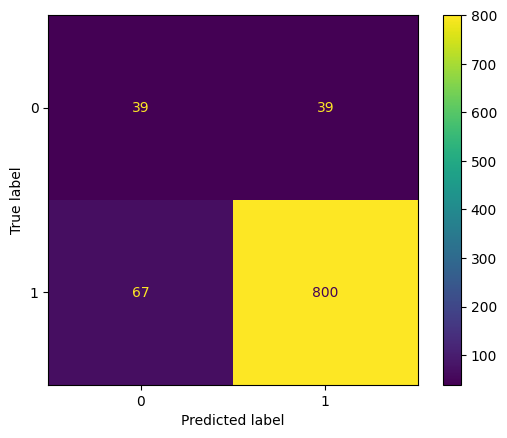

In [65]:
#displaying confusion matrix
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_dt.classes_)
cm_display.plot()

From the above finding, we can choose our desired model with the highest accuracy. In our case, the highest accuracy model is Random Forest Classifier and Decision Tree Classifier. Now by using any of the desired model, we are going to build a flask app which will be beneficial to work with the trained datas. Ok, thats it for now see you in flask app, Thank You!!!!!!!!!!